# PhysioNet Motor Imagery - Gating Methods Comparison

This notebook compares four different gating methods:
1. **Baseline EEG-ARNN** - Pure CNN-GCN architecture (no gating)
2. **Static Gating** - Fixed channel gates learned during training
3. **Adaptive Gating** - Dynamic gates that adapt per input
4. **Early Halting** - Progressive channel dropout with early stopping

All methods include:
- Proper data cleaning (removing faulty subjects)
- In-notebook preprocessing with MNE
- Cross-validation
- Channel importance analysis

## 1. Setup and Imports

In [1]:
import json
import random
import warnings
from pathlib import Path
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

import mne

warnings.filterwarnings('ignore')
sns.set_context('notebook', font_scale=1.0)
mne.set_log_level('WARNING')

def set_seed(s=42):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


## 2. Configuration

In [2]:
# Auto-detect Kaggle environment
import os
if os.path.exists('/kaggle/input'):
    print("Running on Kaggle")
    kaggle_input = Path('/kaggle/input')
    datasets = [d for d in kaggle_input.iterdir() if d.is_dir()]
    print(f"Available datasets: {[d.name for d in datasets]}")
    
    DATA_DIR = None
    possible_names = ['physioneteegmi', 'eeg-motor-movementimagery-dataset']
    for ds_name in possible_names:
        test_path = kaggle_input / ds_name
        if test_path.exists():
            DATA_DIR = test_path
            print(f"Found dataset: {DATA_DIR}")
            break
    
    if DATA_DIR is None and datasets:
        DATA_DIR = datasets[0]
        print(f"Using first available dataset: {DATA_DIR}")
else:
    print("Running locally")
    DATA_DIR = Path('data/physionet/files')

CONFIG = {
    'data': {
        'raw_data_dir': DATA_DIR,
        'selected_classes': [1, 2],  # T1 (left fist), T2 (right fist)
        'tmin': -1.0,
        'tmax': 5.0,
        'baseline': (-0.5, 0)
    },
    'preprocessing': {
        'l_freq': 0.5,
        'h_freq': 40.0,
        'notch_freq': 50.0,
        'target_sfreq': 128.0,
        'apply_car': True
    },
    'model': {
        'hidden_dim': 40,
        'epochs': 30,
        'learning_rate': 1e-3,
        'batch_size': 32,
        'n_folds': 3,
        'patience': 8
    },
    'gating': {
        'l1_lambda': 1e-3,
        'gate_init': 0.9,
        'halting_threshold': 0.5,
        'halting_penalty': 1e-2
    },
    'output': {
        'results_dir': Path('results'),
    },
    'max_subjects': 20,
    'min_runs_per_subject': 8
}

CONFIG['output']['results_dir'].mkdir(exist_ok=True, parents=True)
print(f"\nConfiguration loaded!")
print(f"Training: {CONFIG['max_subjects']} subjects, {CONFIG['model']['n_folds']}-fold CV, {CONFIG['model']['epochs']} epochs")

Running on Kaggle
Available datasets: ['physioneteegmi']
Found dataset: /kaggle/input/physioneteegmi

Configuration loaded!
Training: 20 subjects, 3-fold CV, 30 epochs


## 3. Data Cleaning - Remove Faulty Subjects

In [3]:
# Known faulty subjects from data cleaning analysis
KNOWN_BAD_SUBJECTS = [
    'S088', 'S089', 'S092', 'S100', 'S104', 'S106', 'S107', 'S108', 'S109'
]

# Additional subjects with high clipping or amplitude issues
HIGH_ISSUE_SUBJECTS = [
    'S003', 'S004', 'S009', 'S010', 'S012', 'S013', 'S017', 'S018', 'S019',
    'S021', 'S022', 'S023', 'S024', 'S025', 'S026', 'S027', 'S028', 'S029'
]

EXCLUDED_SUBJECTS = set(KNOWN_BAD_SUBJECTS + HIGH_ISSUE_SUBJECTS)

print(f"Total excluded subjects: {len(EXCLUDED_SUBJECTS)}")
print(f"Excluded subjects: {sorted(EXCLUDED_SUBJECTS)}")

Total excluded subjects: 27
Excluded subjects: ['S003', 'S004', 'S009', 'S010', 'S012', 'S013', 'S017', 'S018', 'S019', 'S021', 'S022', 'S023', 'S024', 'S025', 'S026', 'S027', 'S028', 'S029', 'S088', 'S089', 'S092', 'S100', 'S104', 'S106', 'S107', 'S108', 'S109']


## 4. Data Loading and Preprocessing Functions

In [4]:
def preprocess_raw(raw, config):
    """Apply preprocessing to raw EEG data."""
    cleaned_names = {name: name.rstrip('.') for name in raw.ch_names}
    raw.rename_channels(cleaned_names)
    raw.pick_types(eeg=True)
    raw.set_montage('standard_1020', on_missing='ignore', match_case=False)
    
    nyquist = raw.info['sfreq'] / 2.0
    if config['preprocessing']['notch_freq'] < nyquist:
        raw.notch_filter(freqs=config['preprocessing']['notch_freq'], verbose=False)
    
    raw.filter(
        l_freq=config['preprocessing']['l_freq'],
        h_freq=config['preprocessing']['h_freq'],
        method='fir',
        fir_design='firwin',
        verbose=False
    )
    
    if config['preprocessing']['apply_car']:
        raw.set_eeg_reference('average', projection=False, verbose=False)
    
    raw.resample(config['preprocessing']['target_sfreq'], npad='auto', verbose=False)
    return raw


def load_and_preprocess_edf(edf_path, config):
    """Load raw EDF file, preprocess it, and extract epochs."""
    raw = mne.io.read_raw_edf(edf_path, preload=True, verbose='ERROR')
    raw = preprocess_raw(raw, config)
    
    # Use events_from_annotations to get correct event IDs
    events, event_ids = mne.events_from_annotations(raw, verbose='ERROR')
    
    if len(events) == 0:
        return None, None, raw.ch_names
    
    epochs = mne.Epochs(
        raw,
        events,
        event_id=event_ids,
        tmin=config['data']['tmin'],
        tmax=config['data']['tmax'],
        baseline=tuple(config['data']['baseline']),
        preload=True,
        verbose='ERROR'
    )
    
    return epochs.get_data(), epochs.events[:, 2], raw.ch_names


def filter_classes(x, y, selected_classes):
    """Filter to keep only selected classes and remap labels."""
    mask = np.isin(y, selected_classes)
    y, x = y[mask], x[mask]
    label_map = {old: new for new, old in enumerate(sorted(selected_classes))}
    y = np.array([label_map[int(label)] for label in y], dtype=np.int64)
    return x, y


def normalize(x):
    """Z-score normalization per channel."""
    mu = x.mean(axis=(0, 2), keepdims=True)
    sd = x.std(axis=(0, 2), keepdims=True) + 1e-8
    return (x - mu) / sd


def load_subject_data(data_dir, subject_id, run_ids, config):
    """Load all runs for a subject, preprocess, and concatenate."""
    subject_dir = data_dir / subject_id
    if not subject_dir.exists():
        return None, None, None
    
    all_x, all_y = [], []
    channel_names = None
    
    for run_id in run_ids:
        edf_path = subject_dir / f'{subject_id}{run_id}.edf'
        if not edf_path.exists():
            continue
        
        try:
            x, y, ch_names = load_and_preprocess_edf(edf_path, config)
            if x is None or len(y) == 0:
                continue
            
            x, y = filter_classes(x, y, config['data']['selected_classes'])
            if len(y) == 0:
                continue
            
            channel_names = channel_names or ch_names
            all_x.append(x)
            all_y.append(y)
        except Exception as e:
            print(f"  Warning: Failed to load {edf_path.name}: {e}")
            continue
    
    if len(all_x) == 0:
        return None, None, channel_names
    
    return np.concatenate(all_x, 0), np.concatenate(all_y, 0), channel_names


def get_available_subjects(data_dir, min_runs=8, excluded=None):
    """Get list of subjects with at least min_runs available, excluding bad subjects."""
    if not data_dir.exists():
        raise ValueError(f"Data directory not found: {data_dir}")
    
    excluded = excluded or set()
    subjects = []
    
    for subject_dir in sorted(data_dir.iterdir()):
        if not subject_dir.is_dir() or not subject_dir.name.startswith('S'):
            continue
        
        # Skip excluded subjects
        if subject_dir.name in excluded:
            continue
        
        edf_files = list(subject_dir.glob('*.edf'))
        if len(edf_files) >= min_runs:
            subjects.append(subject_dir.name)
    
    return subjects


# Scan for available subjects
print("\nScanning for subjects...")
data_dir = CONFIG['data']['raw_data_dir']
print(f"Looking for data in: {data_dir}")

all_subjects = get_available_subjects(
    data_dir, 
    min_runs=CONFIG['min_runs_per_subject'],
    excluded=EXCLUDED_SUBJECTS
)
subjects = all_subjects[:CONFIG['max_subjects']]

print(f"Found {len(all_subjects)} clean subjects with >= {CONFIG['min_runs_per_subject']} runs")
print(f"Will process {len(subjects)} subjects: {subjects}")

# Define which runs to use
MOTOR_IMAGERY_RUNS = ['R07', 'R08', 'R09', 'R10', 'R11', 'R12', 'R13', 'R14']
MOTOR_EXECUTION_RUNS = ['R03', 'R04', 'R05', 'R06']
ALL_TASK_RUNS = MOTOR_IMAGERY_RUNS + MOTOR_EXECUTION_RUNS
print(f"Using runs: {ALL_TASK_RUNS}")


Scanning for subjects...
Looking for data in: /kaggle/input/physioneteegmi
Found 82 clean subjects with >= 8 runs
Will process 20 subjects: ['S001', 'S002', 'S005', 'S006', 'S007', 'S008', 'S011', 'S014', 'S015', 'S016', 'S020', 'S030', 'S031', 'S032', 'S033', 'S034', 'S035', 'S036', 'S037', 'S038']
Using runs: ['R07', 'R08', 'R09', 'R10', 'R11', 'R12', 'R13', 'R14', 'R03', 'R04', 'R05', 'R06']


## 5. PyTorch Dataset

In [5]:
class EEGDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.FloatTensor(x).unsqueeze(1)  # Add channel dim for Conv2d
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

## 6. Model Architectures

### 6.1 Baseline Components

In [6]:
class GraphConvLayer(nn.Module):
    """Graph Convolution Layer with learned adjacency."""
    def __init__(self, num_channels, hidden_dim):
        super().__init__()
        self.num_channels = num_channels
        self.hidden_dim = hidden_dim
        
        # Learnable adjacency matrix
        self.A = nn.Parameter(torch.randn(num_channels, num_channels))
        self.theta = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.bn = nn.BatchNorm2d(hidden_dim)
        self.act = nn.ELU()
    
    def forward(self, x):
        B, H, C, T = x.shape
        
        # Normalize adjacency matrix
        A = torch.sigmoid(self.A)
        A = 0.5 * (A + A.t())
        I = torch.eye(C, device=A.device)
        A_hat = A + I
        D = torch.diag(torch.pow(A_hat.sum(1).clamp_min(1e-6), -0.5))
        A_norm = D @ A_hat @ D
        
        # Graph convolution
        x_batch = x.permute(0, 3, 2, 1).contiguous().view(B*T, C, H)
        x_g = A_norm @ x_batch
        x_g = self.theta(x_g)
        x_g = x_g.view(B, T, C, H).permute(0, 3, 2, 1)
        
        x_out = self.bn(x_g)
        x_out = self.act(x_out)
        
        return x_out
    
    def get_adjacency(self):
        with torch.no_grad():
            A = torch.sigmoid(self.A)
            A = 0.5 * (A + A.t())
            return A.cpu().numpy()


class TemporalConv(nn.Module):
    """Temporal Convolution Layer."""
    def __init__(self, in_channels, out_channels, kernel_size=16, pool=True):
        super().__init__()
        self.pool = pool
        self.conv = nn.Conv2d(in_channels, out_channels, 
                            kernel_size=(1, kernel_size), 
                            padding=(0, kernel_size//2), bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ELU()
        self.pool_layer = nn.AvgPool2d(kernel_size=(1, 2)) if pool else None
    
    def forward(self, x):
        x = self.act(self.bn(self.conv(x)))
        return self.pool_layer(x) if self.pool else x


class BaselineEEGARNN(nn.Module):
    """Baseline EEG-ARNN with pure CNN-GCN architecture."""
    def __init__(self, C, T, K, H):
        super().__init__()
        self.t1 = TemporalConv(1, H, 16, False)
        self.g1 = GraphConvLayer(C, H)
        self.t2 = TemporalConv(H, H, 16, True)
        self.g2 = GraphConvLayer(C, H)
        self.t3 = TemporalConv(H, H, 16, True)
        self.g3 = GraphConvLayer(C, H)
        
        with torch.no_grad():
            ft = self._forward_features(torch.zeros(1, 1, C, T))
            fs = ft.view(1, -1).size(1)
        
        self.fc1 = nn.Linear(fs, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, K)
    
    def _forward_features(self, x):
        x = self.g1(self.t1(x))
        x = self.g2(self.t2(x))
        x = self.g3(self.t3(x))
        return x
    
    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)
    
    def get_final_adjacency(self):
        return self.g3.get_adjacency()


print("Baseline EEG-ARNN architecture defined!")

Baseline EEG-ARNN architecture defined!


### 6.2 Static Gating

In [7]:
class StaticGatedEEGARNN(BaselineEEGARNN):
    """EEG-ARNN with static learnable channel gates."""
    def __init__(self, C, T, K, H, gate_init=0.9):
        super().__init__(C, T, K, H)
        init = torch.full((C,), float(gate_init), dtype=torch.float32)
        init = torch.clamp(init, 1e-4, 1 - 1e-4)
        gate_logits = torch.logit(init)
        self.gate_logits = nn.Parameter(gate_logits)
        self.latest_gates = None
    
    def get_gate_values(self):
        return torch.sigmoid(self.gate_logits)
    
    def forward(self, x):
        gate_values = torch.sigmoid(self.gate_logits)
        self.latest_gates = gate_values.detach().cpu()
        x = x * gate_values.view(1, 1, -1, 1)
        return super().forward(x)


print("Static Gating architecture defined!")

Static Gating architecture defined!


### 6.3 Adaptive Gating

In [8]:
class AdaptiveGatedEEGARNN(BaselineEEGARNN):
    """EEG-ARNN with adaptive input-dependent channel gates."""
    def __init__(self, C, T, K, H, gate_init=0.9):
        super().__init__(C, T, K, H)
        
        # Gate network: computes gates from input statistics
        self.gate_net = nn.Sequential(
            nn.Linear(C * 2, C),  # Input: mean and std per channel
            nn.ReLU(),
            nn.Linear(C, C),
            nn.Sigmoid()
        )
        
        # Initialize to produce values around gate_init
        with torch.no_grad():
            self.gate_net[-2].bias.fill_(2.0)  # Bias toward high values
        
        self.latest_gates = None
    
    def compute_gates(self, x):
        """Compute adaptive gates from input."""
        B, _, C, T = x.shape
        
        # Compute channel statistics
        x_squeeze = x.squeeze(1)  # (B, C, T)
        ch_mean = x_squeeze.mean(dim=2)  # (B, C)
        ch_std = x_squeeze.std(dim=2)    # (B, C)
        
        # Concatenate statistics
        stats = torch.cat([ch_mean, ch_std], dim=1)  # (B, 2*C)
        
        # Compute gates
        gates = self.gate_net(stats)  # (B, C)
        
        return gates
    
    def forward(self, x):
        gates = self.compute_gates(x)  # (B, C)
        self.latest_gates = gates.detach().cpu()
        
        # Apply gates
        x = x * gates.view(-1, 1, gates.size(1), 1)
        
        return super().forward(x)
    
    def get_gate_values(self):
        """Return average gate values from last forward pass."""
        if self.latest_gates is not None:
            return self.latest_gates.mean(dim=0)
        return None


print("Adaptive Gating architecture defined!")

Adaptive Gating architecture defined!


### 6.4 Early Halting (Progressive Channel Dropout)

In [9]:
class EarlyHaltingEEGARNN(BaselineEEGARNN):
    """EEG-ARNN with progressive channel halting."""
    def __init__(self, C, T, K, H, halt_threshold=0.5):
        super().__init__(C, T, K, H)
        
        # Halting network: decides when to stop using each channel
        self.halt_net = nn.Sequential(
            nn.Linear(C * 2, C),
            nn.ReLU(),
            nn.Linear(C, C),
            nn.Sigmoid()
        )
        
        self.halt_threshold = halt_threshold
        self.latest_halt_probs = None
        self.latest_active_mask = None
    
    def compute_halting_probs(self, x):
        """Compute halting probabilities for each channel."""
        B, _, C, T = x.shape
        
        # Compute channel statistics
        x_squeeze = x.squeeze(1)  # (B, C, T)
        ch_mean = x_squeeze.mean(dim=2)  # (B, C)
        ch_std = x_squeeze.std(dim=2)    # (B, C)
        
        # Concatenate statistics
        stats = torch.cat([ch_mean, ch_std], dim=1)  # (B, 2*C)
        
        # Compute halting probabilities
        halt_probs = self.halt_net(stats)  # (B, C)
        
        return halt_probs
    
    def forward(self, x):
        halt_probs = self.compute_halting_probs(x)  # (B, C)
        self.latest_halt_probs = halt_probs.detach().cpu()
        
        # Create active mask (1 = keep, 0 = halt)
        if self.training:
            # During training: soft masking
            active_mask = 1.0 - halt_probs
        else:
            # During inference: hard masking
            active_mask = (halt_probs < self.halt_threshold).float()
        
        self.latest_active_mask = active_mask.detach().cpu()
        
        # Apply mask
        x = x * active_mask.view(-1, 1, active_mask.size(1), 1)
        
        return super().forward(x)
    
    def get_gate_values(self):
        """Return average active channel mask from last forward pass."""
        if self.latest_active_mask is not None:
            return self.latest_active_mask.mean(dim=0)
        return None


print("Early Halting architecture defined!")

Early Halting architecture defined!


## 7. Training Functions

In [10]:
def train_epoch(model, dataloader, criterion, optimizer, device, l1_lambda=0.0, halt_penalty=0.0):
    model.train()
    total_loss = 0.0
    all_preds, all_labels = [], []
    
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        
        # Add L1 regularization for gated models
        if l1_lambda > 0 and hasattr(model, 'get_gate_values'):
            gate_values = model.get_gate_values()
            if gate_values is not None:
                if gate_values.dim() == 0:
                    gate_values = gate_values.unsqueeze(0)
                loss = loss + l1_lambda * gate_values.abs().mean()
        
        # Add halting penalty (encourage using fewer channels)
        if halt_penalty > 0 and hasattr(model, 'latest_active_mask'):
            if model.latest_active_mask is not None:
                active_count = model.latest_active_mask.mean()
                loss = loss + halt_penalty * active_count
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        all_preds += torch.argmax(logits, 1).cpu().tolist()
        all_labels += y.cpu().tolist()
    
    return total_loss / max(1, len(dataloader)), accuracy_score(all_labels, all_preds)


@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [], []
    
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        
        total_loss += loss.item()
        all_preds += torch.argmax(logits, 1).cpu().tolist()
        all_labels += y.cpu().tolist()
    
    return total_loss / max(1, len(dataloader)), accuracy_score(all_labels, all_preds)


def train_model(model, train_loader, val_loader, device, epochs, lr, patience, l1_lambda=0.0, halt_penalty=0.0):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=False
    )
    
    best_acc = 0.0
    best_state = None
    no_improve = 0
    
    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, l1_lambda, halt_penalty)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        
        scheduler.step(val_loss)
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_state = deepcopy(model.state_dict())
            no_improve = 0
        else:
            no_improve += 1
        
        if no_improve >= patience:
            break
    
    if best_state is None:
        best_state = deepcopy(model.state_dict())
    
    model.load_state_dict(best_state)
    return best_state, best_acc


print("Training functions defined!")

Training functions defined!


## 8. Cross-Validation Function

In [11]:
def cross_validate_subject(x, y, channel_names, T, K, device, config, model_type='baseline'):
    """Cross-validate subject with specified model type."""
    C = x.shape[1]
    skf = StratifiedKFold(n_splits=config['model']['n_folds'], shuffle=True, random_state=42)
    
    batch_size = config['model']['batch_size']
    epochs = config['model']['epochs']
    lr = config['model']['learning_rate']
    patience = config['model']['patience']
    
    folds = []
    adjacencies = []
    gate_values_list = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(x, y)):
        X_train, X_val = normalize(x[train_idx]), normalize(x[val_idx])
        Y_train, Y_val = y[train_idx], y[val_idx]
        
        train_loader = DataLoader(
            EEGDataset(X_train, Y_train),
            batch_size=batch_size,
            shuffle=True,
            num_workers=0
        )
        val_loader = DataLoader(
            EEGDataset(X_val, Y_val),
            batch_size=batch_size,
            shuffle=False,
            num_workers=0
        )
        
        # Create model based on type
        if model_type == 'baseline':
            model = BaselineEEGARNN(C, T, K, config['model']['hidden_dim']).to(device)
            l1_lambda = 0.0
            halt_penalty = 0.0
        elif model_type == 'static':
            model = StaticGatedEEGARNN(C, T, K, config['model']['hidden_dim'], 
                                      config['gating']['gate_init']).to(device)
            l1_lambda = config['gating']['l1_lambda']
            halt_penalty = 0.0
        elif model_type == 'adaptive':
            model = AdaptiveGatedEEGARNN(C, T, K, config['model']['hidden_dim'],
                                        config['gating']['gate_init']).to(device)
            l1_lambda = config['gating']['l1_lambda']
            halt_penalty = 0.0
        elif model_type == 'halting':
            model = EarlyHaltingEEGARNN(C, T, K, config['model']['hidden_dim'],
                                       config['gating']['halting_threshold']).to(device)
            l1_lambda = 0.0
            halt_penalty = config['gating']['halting_penalty']
        else:
            raise ValueError(f"Unknown model type: {model_type}")
        
        best_state, best_acc = train_model(model, train_loader, val_loader, device, 
                                          epochs, lr, patience, l1_lambda, halt_penalty)
        model.load_state_dict(best_state)
        
        _, accuracy = evaluate(model, val_loader, nn.CrossEntropyLoss(), device)
        
        adjacency = model.get_final_adjacency()
        adjacencies.append(adjacency)
        
        # Get gate values for gated models
        if hasattr(model, 'get_gate_values'):
            gate_values = model.get_gate_values()
            if gate_values is not None:
                if isinstance(gate_values, torch.Tensor):
                    gate_values = gate_values.detach().cpu().numpy()
                gate_values_list.append(gate_values)
        
        folds.append({'fold': fold, 'val_acc': accuracy})
    
    avg_acc = float(np.mean([f['val_acc'] for f in folds]))
    std_acc = float(np.std([f['val_acc'] for f in folds]))
    avg_adjacency = np.mean(np.stack([a for a in adjacencies if a is not None], 0), 0) \
                    if any(a is not None for a in adjacencies) else None
    
    result = {
        'fold_results': folds,
        'avg_accuracy': avg_acc,
        'std_accuracy': std_acc,
        'adjacency_matrix': avg_adjacency,
        'channel_names': channel_names
    }
    
    if gate_values_list:
        result['avg_gate_values'] = np.mean(np.stack(gate_values_list, 0), 0)
    
    return result


print("Cross-validation function defined!")

Cross-validation function defined!


## 9. Main Training Loop

In [12]:
all_results = {
    'baseline': [],
    'static': [],
    'adaptive': [],
    'halting': []
}

print("\nStarting training for all four methods...\n")

for subject_id in tqdm(subjects, desc='Training subjects'):
    print(f"\n{'='*80}")
    print(f"Subject {subject_id}")
    print(f"{'='*80}")
    
    # Load subject data
    X, Y, channel_names = load_subject_data(
        data_dir,
        subject_id,
        ALL_TASK_RUNS,
        CONFIG
    )
    
    if X is None or len(Y) == 0:
        print(f"Skipped: No data available")
        continue
    
    C, T = X.shape[1], X.shape[2]
    K = len(set(CONFIG['data']['selected_classes']))
    
    print(f"Data shape: {X.shape} (trials={X.shape[0]}, channels={C}, timepoints={T})")
    print(f"Label distribution: {np.bincount(Y)}")
    
    # Train all four methods
    for model_type in ['baseline', 'static', 'adaptive', 'halting']:
        print(f"\nTraining {model_type.upper()}...")
        result = cross_validate_subject(X, Y, channel_names, T, K, device, CONFIG, model_type)
        
        print(f"  Accuracy: {result['avg_accuracy']:.4f} ± {result['std_accuracy']:.4f}")
        
        all_results[model_type].append({
            'subject': subject_id,
            'num_trials': X.shape[0],
            'num_channels': C,
            'accuracy': result['avg_accuracy'],
            'std': result['std_accuracy'],
            'adjacency_matrix': result['adjacency_matrix'],
            'channel_names': result['channel_names'],
            'gate_values': result.get('avg_gate_values', None)
        })

print("\n" + "="*80)
print("Training Complete!")
print("="*80)


Starting training for all four methods...



Training subjects:   0%|          | 0/20 [00:00<?, ?it/s]


Subject S001
Data shape: (252, 64, 769) (trials=252, channels=64, timepoints=769)
Label distribution: [168  84]

Training BASELINE...
  Accuracy: 0.8175 ± 0.0281

Training STATIC...
  Accuracy: 0.8373 ± 0.0393

Training ADAPTIVE...
  Accuracy: 0.8810 ± 0.0097

Training HALTING...
  Accuracy: 0.8571 ± 0.0000

Subject S002
Data shape: (252, 64, 769) (trials=252, channels=64, timepoints=769)
Label distribution: [168  84]

Training BASELINE...
  Accuracy: 0.8056 ± 0.0112

Training STATIC...
  Accuracy: 0.7857 ± 0.0257

Training ADAPTIVE...
  Accuracy: 0.7738 ± 0.0350

Training HALTING...
  Accuracy: 0.7857 ± 0.0389

Subject S005
Data shape: (252, 64, 769) (trials=252, channels=64, timepoints=769)
Label distribution: [168  84]

Training BASELINE...
  Accuracy: 0.8214 ± 0.0257

Training STATIC...
  Accuracy: 0.8929 ± 0.0194

Training ADAPTIVE...
  Accuracy: 0.8571 ± 0.0337

Training HALTING...
  Accuracy: 0.8452 ± 0.0350

Subject S006
Data shape: (252, 64, 769) (trials=252, channels=64, tim

## 10. Results Summary

In [13]:
# Create DataFrames
results_dfs = {}
for model_type in ['baseline', 'static', 'adaptive', 'halting']:
    if len(all_results[model_type]) > 0:
        df = pd.DataFrame(all_results[model_type])
        results_dfs[model_type] = df[['subject', 'num_trials', 'num_channels', 'accuracy', 'std']]

# Print summary
print("\n" + "="*80)
print("RESULTS SUMMARY")
print("="*80 + "\n")

for model_type in ['baseline', 'static', 'adaptive', 'halting']:
    if model_type in results_dfs:
        df = results_dfs[model_type]
        print(f"{model_type.upper()} Results:")
        print(f"  Subjects: {len(df)}")
        print(f"  Mean accuracy: {df['accuracy'].mean():.4f} ± {df['accuracy'].std():.4f}")
        print(f"  Best: {df['accuracy'].max():.4f} (Subject {df.loc[df['accuracy'].idxmax(), 'subject']})")
        print(f"  Worst: {df['accuracy'].min():.4f} (Subject {df.loc[df['accuracy'].idxmin(), 'subject']})")
        print()

# Save results
results_dir = CONFIG['output']['results_dir']
for model_type, df in results_dfs.items():
    df.to_csv(results_dir / f'{model_type}_gating_results.csv', index=False)

print(f"Results saved to {results_dir}")


RESULTS SUMMARY

BASELINE Results:
  Subjects: 20
  Mean accuracy: 0.8673 ± 0.0516
  Best: 0.9683 (Subject S020)
  Worst: 0.7778 (Subject S006)

STATIC Results:
  Subjects: 20
  Mean accuracy: 0.8714 ± 0.0476
  Best: 0.9563 (Subject S020)
  Worst: 0.7857 (Subject S002)

ADAPTIVE Results:
  Subjects: 20
  Mean accuracy: 0.8728 ± 0.0510
  Best: 0.9762 (Subject S020)
  Worst: 0.7738 (Subject S002)

HALTING Results:
  Subjects: 20
  Mean accuracy: 0.8530 ± 0.0517
  Best: 0.9643 (Subject S020)
  Worst: 0.7381 (Subject S038)

Results saved to results


## 11. Visualization

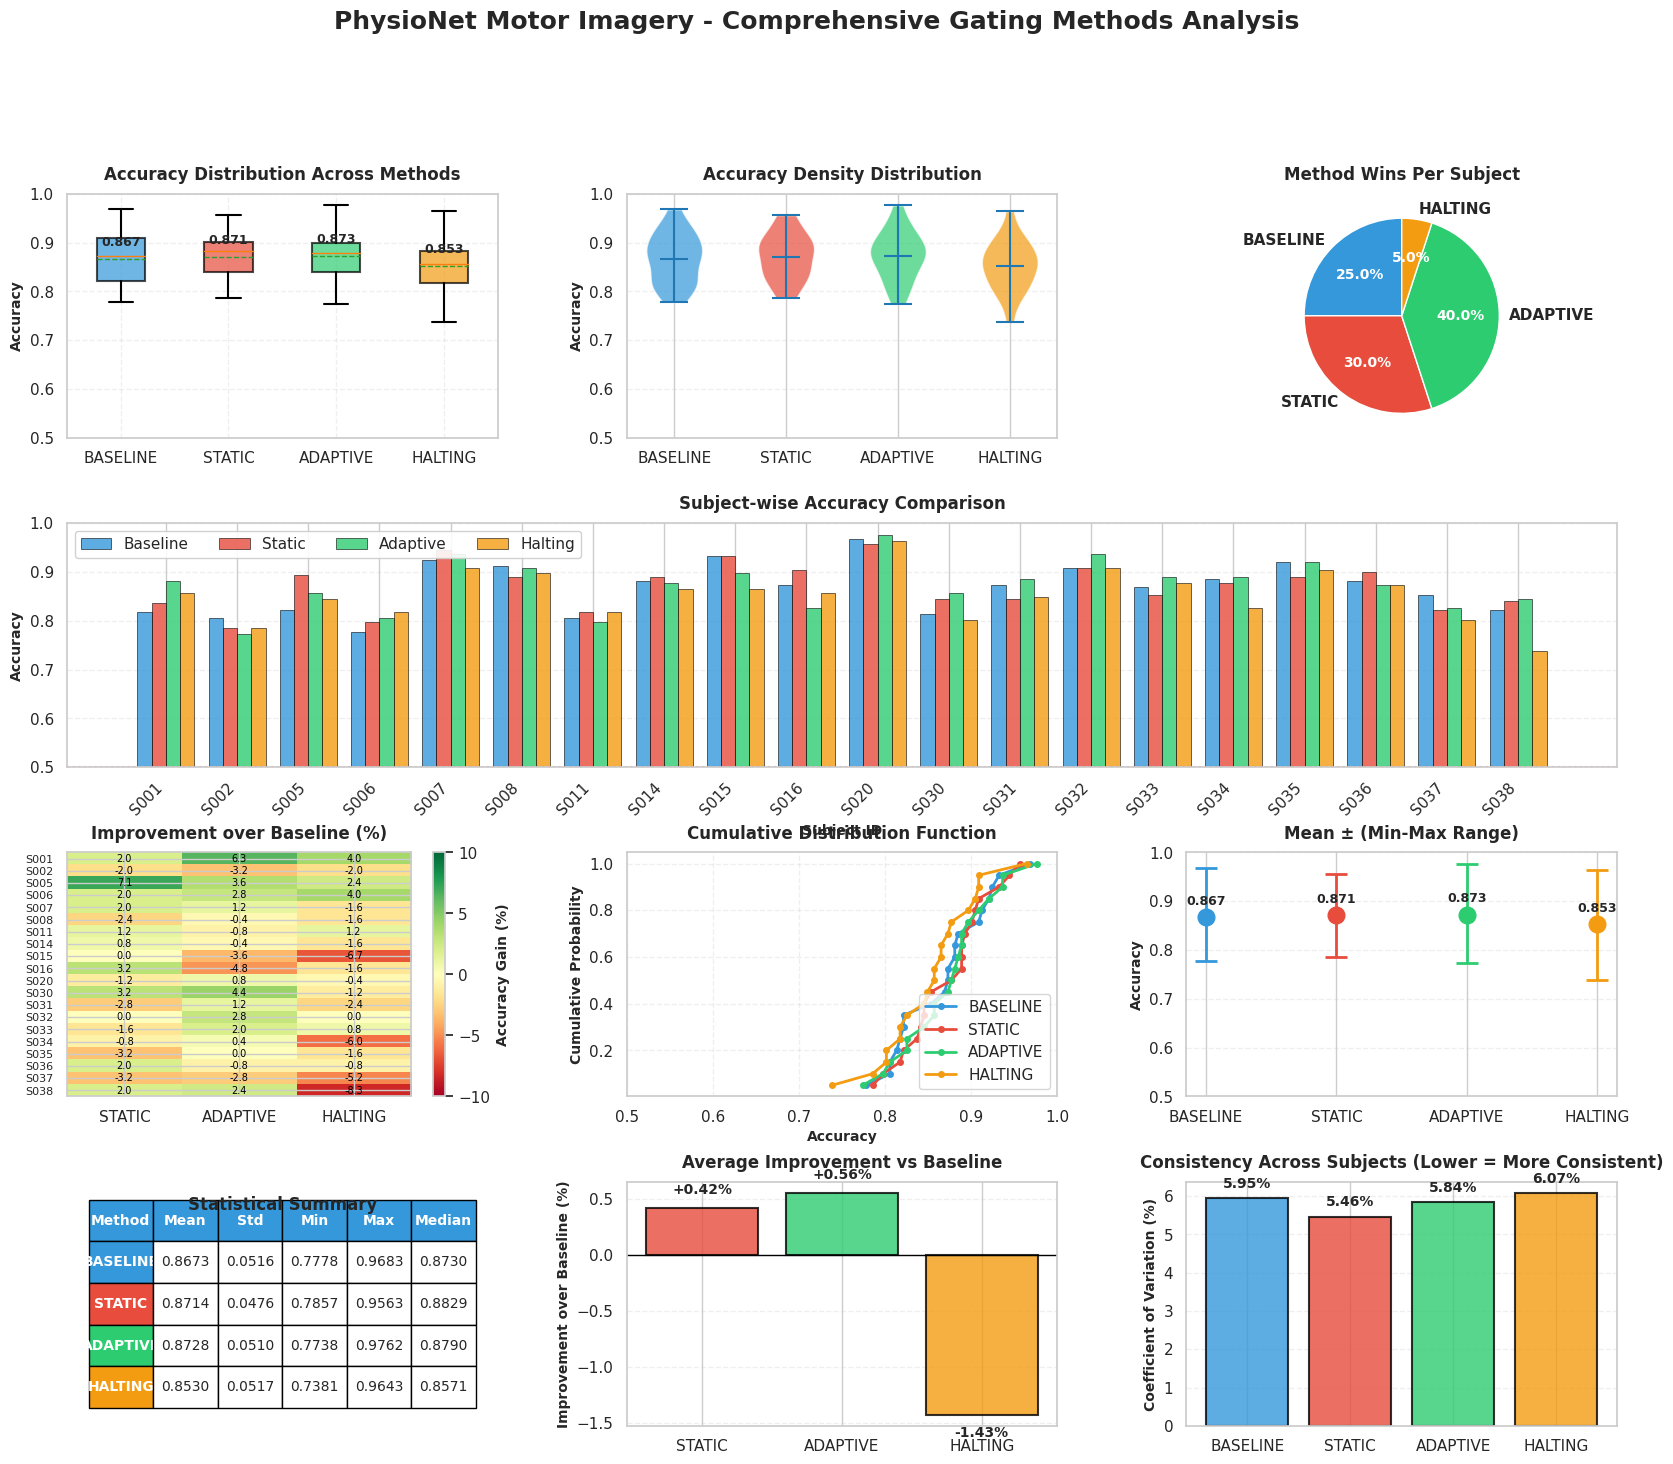


Enhanced visualization complete!

Generating channel importance visualizations...


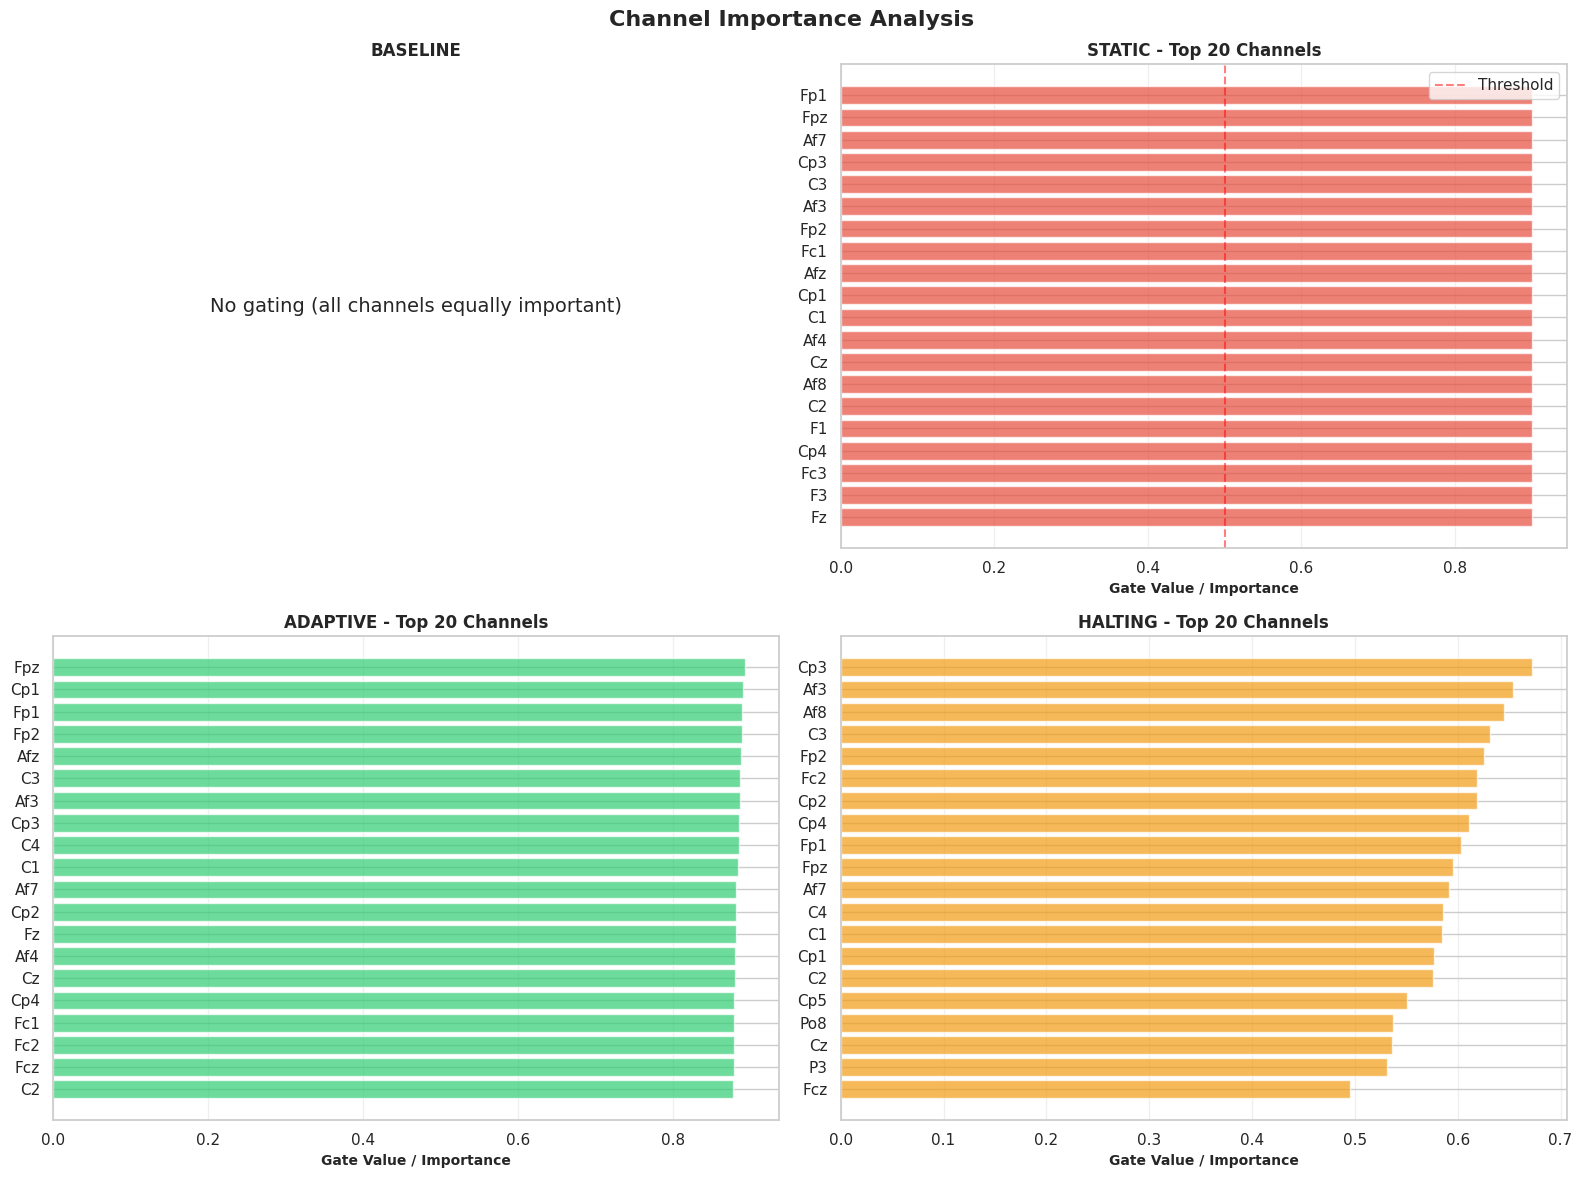

Channel importance visualizations complete!

All visualizations saved to: results


In [14]:
"""
Enhanced Visualizations for Gating Methods Comparison

Replace the visualization cell (cell 11) in the notebook with this code
for much better, more insightful visualizations.
"""

# ============================================================================
# ENHANCED VISUALIZATION CODE - Copy this to your notebook
# ============================================================================

import warnings
warnings.filterwarnings('ignore')

# Set superior plotting style
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10

colors = {
    'baseline': '#3498db',  # Blue
    'static': '#e74c3c',    # Red
    'adaptive': '#2ecc71',  # Green
    'halting': '#f39c12'    # Orange
}

# Create comprehensive figure
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)

# ============================================================================
# 1. BOX PLOT - Accuracy Distribution
# ============================================================================
ax1 = fig.add_subplot(gs[0, 0])
data_for_box = []
labels_for_box = []
for model_type in ['baseline', 'static', 'adaptive', 'halting']:
    if model_type in results_dfs:
        data_for_box.append(results_dfs[model_type]['accuracy'].values)
        labels_for_box.append(model_type.upper())

bp = ax1.boxplot(data_for_box, labels=labels_for_box, patch_artist=True,
                showmeans=True, meanline=True,
                boxprops=dict(linewidth=1.5),
                whiskerprops=dict(linewidth=1.5),
                capprops=dict(linewidth=1.5))

for patch, model in zip(bp['boxes'], ['baseline', 'static', 'adaptive', 'halting']):
    patch.set_facecolor(colors[model])
    patch.set_alpha(0.7)

ax1.set_ylabel('Accuracy', fontweight='bold')
ax1.set_title('Accuracy Distribution Across Methods', fontweight='bold', pad=10)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_ylim([0.5, 1.0])

# Add mean value annotations
for i, model in enumerate(['baseline', 'static', 'adaptive', 'halting']):
    if model in results_dfs:
        mean_val = results_dfs[model]['accuracy'].mean()
        ax1.text(i+1, mean_val + 0.02, f'{mean_val:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# ============================================================================
# 2. VIOLIN PLOT - Detailed Distribution
# ============================================================================
ax2 = fig.add_subplot(gs[0, 1])
violin_data = []
violin_labels = []
for model_type in ['baseline', 'static', 'adaptive', 'halting']:
    if model_type in results_dfs:
        violin_data.append(results_dfs[model_type]['accuracy'].values)
        violin_labels.append(model_type.upper())

parts = ax2.violinplot(violin_data, positions=range(1, len(violin_data)+1),
                      showmeans=True, showextrema=True)

for i, (pc, model) in enumerate(zip(parts['bodies'], ['baseline', 'static', 'adaptive', 'halting'])):
    pc.set_facecolor(colors[model])
    pc.set_alpha(0.7)

ax2.set_xticks(range(1, len(violin_labels)+1))
ax2.set_xticklabels(violin_labels)
ax2.set_ylabel('Accuracy', fontweight='bold')
ax2.set_title('Accuracy Density Distribution', fontweight='bold', pad=10)
ax2.grid(True, alpha=0.3, axis='y', linestyle='--')
ax2.set_ylim([0.5, 1.0])

# ============================================================================
# 3. RANKING COMPARISON - Which method wins per subject?
# ============================================================================
ax3 = fig.add_subplot(gs[0, 2])
if all(m in results_dfs for m in ['baseline', 'static', 'adaptive', 'halting']):
    # Count wins for each method
    win_counts = {'baseline': 0, 'static': 0, 'adaptive': 0, 'halting': 0}

    for idx in range(len(results_dfs['baseline'])):
        accs = {
            'baseline': results_dfs['baseline'].iloc[idx]['accuracy'],
            'static': results_dfs['static'].iloc[idx]['accuracy'],
            'adaptive': results_dfs['adaptive'].iloc[idx]['accuracy'],
            'halting': results_dfs['halting'].iloc[idx]['accuracy']
        }
        winner = max(accs, key=accs.get)
        win_counts[winner] += 1

    # Create pie chart
    methods = list(win_counts.keys())
    counts = list(win_counts.values())
    method_colors = [colors[m] for m in methods]

    wedges, texts, autotexts = ax3.pie(counts, labels=[m.upper() for m in methods],
                                        colors=method_colors, autopct='%1.1f%%',
                                        startangle=90, textprops={'fontweight': 'bold'})

    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(10)

    ax3.set_title('Method Wins Per Subject', fontweight='bold', pad=10)

# ============================================================================
# 4. SUBJECT-WISE BAR CHART
# ============================================================================
ax4 = fig.add_subplot(gs[1, :])
if all(m in results_dfs for m in ['baseline', 'static', 'adaptive', 'halting']):
    subjects_plot = results_dfs['baseline']['subject'].values
    x = np.arange(len(subjects_plot))
    width = 0.2

    bars1 = ax4.bar(x - 1.5*width, results_dfs['baseline']['accuracy'].values, width,
                   label='Baseline', color=colors['baseline'], alpha=0.8, edgecolor='black', linewidth=0.5)
    bars2 = ax4.bar(x - 0.5*width, results_dfs['static']['accuracy'].values, width,
                   label='Static', color=colors['static'], alpha=0.8, edgecolor='black', linewidth=0.5)
    bars3 = ax4.bar(x + 0.5*width, results_dfs['adaptive']['accuracy'].values, width,
                   label='Adaptive', color=colors['adaptive'], alpha=0.8, edgecolor='black', linewidth=0.5)
    bars4 = ax4.bar(x + 1.5*width, results_dfs['halting']['accuracy'].values, width,
                   label='Halting', color=colors['halting'], alpha=0.8, edgecolor='black', linewidth=0.5)

    ax4.set_xticks(x)
    ax4.set_xticklabels(subjects_plot, rotation=45, ha='right')
    ax4.set_ylabel('Accuracy', fontweight='bold')
    ax4.set_xlabel('Subject ID', fontweight='bold')
    ax4.set_title('Subject-wise Accuracy Comparison', fontweight='bold', pad=10)
    ax4.legend(loc='upper left', ncol=4, framealpha=0.9)
    ax4.grid(True, alpha=0.3, axis='y', linestyle='--')
    ax4.axhline(y=0.5, color='red', linestyle=':', alpha=0.5, label='Chance')
    ax4.set_ylim([0.5, 1.0])

# ============================================================================
# 5. IMPROVEMENT OVER BASELINE - Heatmap
# ============================================================================
ax5 = fig.add_subplot(gs[2, 0])
if all(m in results_dfs for m in ['baseline', 'static', 'adaptive', 'halting']):
    # Calculate improvements
    improvements = []
    for model in ['static', 'adaptive', 'halting']:
        diff = (results_dfs[model]['accuracy'].values -
                results_dfs['baseline']['accuracy'].values) * 100
        improvements.append(diff)

    improvements = np.array(improvements).T

    im = ax5.imshow(improvements, cmap='RdYlGn', aspect='auto', vmin=-10, vmax=10)
    ax5.set_xticks(range(3))
    ax5.set_xticklabels(['STATIC', 'ADAPTIVE', 'HALTING'])
    ax5.set_yticks(range(len(subjects_plot)))
    ax5.set_yticklabels(subjects_plot, fontsize=8)
    ax5.set_title('Improvement over Baseline (%)', fontweight='bold', pad=10)

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax5)
    cbar.set_label('Accuracy Gain (%)', fontweight='bold')

    # Add text annotations
    for i in range(len(subjects_plot)):
        for j in range(3):
            text = ax5.text(j, i, f'{improvements[i, j]:.1f}',
                          ha="center", va="center", color="black", fontsize=7)

# ============================================================================
# 6. CUMULATIVE DISTRIBUTION
# ============================================================================
ax6 = fig.add_subplot(gs[2, 1])
for model_type in ['baseline', 'static', 'adaptive', 'halting']:
    if model_type in results_dfs:
        sorted_acc = np.sort(results_dfs[model_type]['accuracy'].values)
        cumulative = np.arange(1, len(sorted_acc) + 1) / len(sorted_acc)
        ax6.plot(sorted_acc, cumulative, marker='o', linewidth=2,
                label=model_type.upper(), color=colors[model_type], markersize=4)

ax6.set_xlabel('Accuracy', fontweight='bold')
ax6.set_ylabel('Cumulative Probability', fontweight='bold')
ax6.set_title('Cumulative Distribution Function', fontweight='bold', pad=10)
ax6.legend(loc='lower right')
ax6.grid(True, alpha=0.3, linestyle='--')
ax6.set_xlim([0.5, 1.0])

# ============================================================================
# 7. ACCURACY RANGE (Min-Mean-Max)
# ============================================================================
ax7 = fig.add_subplot(gs[2, 2])
methods_list = []
means_list = []
mins_list = []
maxs_list = []

for model_type in ['baseline', 'static', 'adaptive', 'halting']:
    if model_type in results_dfs:
        methods_list.append(model_type.upper())
        means_list.append(results_dfs[model_type]['accuracy'].mean())
        mins_list.append(results_dfs[model_type]['accuracy'].min())
        maxs_list.append(results_dfs[model_type]['accuracy'].max())

x_pos = np.arange(len(methods_list))
errors_low = np.array(means_list) - np.array(mins_list)
errors_high = np.array(maxs_list) - np.array(means_list)

for i, (method, mean_val) in enumerate(zip(methods_list, means_list)):
    model_type_lower = method.lower()
    ax7.errorbar(i, mean_val, yerr=[[errors_low[i]], [errors_high[i]]],
                fmt='o', markersize=12, capsize=8, capthick=2,
                color=colors[model_type_lower], linewidth=2, label=method)
    ax7.text(i, mean_val + 0.02, f'{mean_val:.3f}',
            ha='center', va='bottom', fontweight='bold', fontsize=9)

ax7.set_xticks(x_pos)
ax7.set_xticklabels(methods_list)
ax7.set_ylabel('Accuracy', fontweight='bold')
ax7.set_title('Mean ± (Min-Max Range)', fontweight='bold', pad=10)
ax7.grid(True, alpha=0.3, axis='y', linestyle='--')
ax7.set_ylim([0.5, 1.0])

# ============================================================================
# 8. STATISTICAL SIGNIFICANCE TABLE
# ============================================================================
ax8 = fig.add_subplot(gs[3, 0])
ax8.axis('tight')
ax8.axis('off')

stats_data = []
for model_type in ['baseline', 'static', 'adaptive', 'halting']:
    if model_type in results_dfs:
        df = results_dfs[model_type]
        stats_data.append([
            model_type.upper(),
            f"{df['accuracy'].mean():.4f}",
            f"{df['accuracy'].std():.4f}",
            f"{df['accuracy'].min():.4f}",
            f"{df['accuracy'].max():.4f}",
            f"{df['accuracy'].median():.4f}"
        ])

table = ax8.table(cellText=stats_data,
                 colLabels=['Method', 'Mean', 'Std', 'Min', 'Max', 'Median'],
                 cellLoc='center', loc='center',
                 colWidths=[0.15, 0.15, 0.15, 0.15, 0.15, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Color header
for i in range(6):
    table[(0, i)].set_facecolor('#3498db')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Color rows
for i, model in enumerate(['baseline', 'static', 'adaptive', 'halting']):
    if i < len(stats_data):
        table[(i+1, 0)].set_facecolor(colors[model])
        table[(i+1, 0)].set_text_props(weight='bold', color='white')

ax8.set_title('Statistical Summary', fontweight='bold', y=0.85, fontsize=12)

# ============================================================================
# 9. IMPROVEMENT SUMMARY BAR CHART
# ============================================================================
ax9 = fig.add_subplot(gs[3, 1])
if all(m in results_dfs for m in ['baseline', 'static', 'adaptive', 'halting']):
    baseline_mean = results_dfs['baseline']['accuracy'].mean()
    improvements_pct = []
    method_names = []

    for model in ['static', 'adaptive', 'halting']:
        improvement = (results_dfs[model]['accuracy'].mean() - baseline_mean) * 100
        improvements_pct.append(improvement)
        method_names.append(model.upper())

    bar_colors = [colors[m.lower()] for m in method_names]
    bars = ax9.bar(range(len(method_names)), improvements_pct, color=bar_colors,
                  alpha=0.8, edgecolor='black', linewidth=1.5)

    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, improvements_pct)):
        height = bar.get_height()
        ax9.text(bar.get_x() + bar.get_width()/2., height + 0.1 if height > 0 else height - 0.1,
                f'{val:+.2f}%', ha='center', va='bottom' if height > 0 else 'top',
                fontweight='bold', fontsize=10)

    ax9.set_xticks(range(len(method_names)))
    ax9.set_xticklabels(method_names)
    ax9.set_ylabel('Improvement over Baseline (%)', fontweight='bold')
    ax9.set_title('Average Improvement vs Baseline', fontweight='bold', pad=10)
    ax9.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax9.grid(True, alpha=0.3, axis='y', linestyle='--')

# ============================================================================
# 10. CONSISTENCY ANALYSIS - Coefficient of Variation
# ============================================================================
ax10 = fig.add_subplot(gs[3, 2])
cv_values = []
method_names_cv = []

for model_type in ['baseline', 'static', 'adaptive', 'halting']:
    if model_type in results_dfs:
        df = results_dfs[model_type]
        # Coefficient of Variation = (std / mean) * 100
        cv = (df['accuracy'].std() / df['accuracy'].mean()) * 100
        cv_values.append(cv)
        method_names_cv.append(model_type.upper())

bar_colors_cv = [colors[m.lower()] for m in method_names_cv]
bars = ax10.bar(range(len(method_names_cv)), cv_values, color=bar_colors_cv,
               alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels
for bar, val in zip(bars, cv_values):
    height = bar.get_height()
    ax10.text(bar.get_x() + bar.get_width()/2., height + 0.2,
             f'{val:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

ax10.set_xticks(range(len(method_names_cv)))
ax10.set_xticklabels(method_names_cv)
ax10.set_ylabel('Coefficient of Variation (%)', fontweight='bold')
ax10.set_title('Consistency Across Subjects (Lower = More Consistent)', fontweight='bold', pad=10)
ax10.grid(True, alpha=0.3, axis='y', linestyle='--')

# ============================================================================
# Overall title
# ============================================================================
plt.suptitle('PhysioNet Motor Imagery - Comprehensive Gating Methods Analysis',
            fontsize=18, fontweight='bold', y=0.995)

plt.savefig(CONFIG['output']['results_dir'] / 'gating_methods_comprehensive.png',
           dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("Enhanced visualization complete!")
print("="*80)

# ============================================================================
# BONUS: Channel Importance Analysis (if gate values available)
# ============================================================================
print("\nGenerating channel importance visualizations...")

fig2, axes2 = plt.subplots(2, 2, figsize=(16, 12))

for idx, model_type in enumerate(['baseline', 'static', 'adaptive', 'halting']):
    ax = axes2[idx // 2, idx % 2]

    if model_type in ['static', 'adaptive', 'halting']:
        # Get average gate values across subjects
        gate_values_all = []
        for result in all_results[model_type]:
            if result['gate_values'] is not None:
                gate_values_all.append(result['gate_values'])

        if gate_values_all:
            avg_gates = np.mean(gate_values_all, axis=0)
            channel_names_list = all_results[model_type][0]['channel_names']

            # Sort by importance
            sorted_idx = np.argsort(avg_gates)[::-1]
            top_20_idx = sorted_idx[:20]

            ax.barh(range(20), avg_gates[top_20_idx], color=colors[model_type], alpha=0.7)
            ax.set_yticks(range(20))
            ax.set_yticklabels([channel_names_list[i] for i in top_20_idx])
            ax.set_xlabel('Gate Value / Importance', fontweight='bold')
            ax.set_title(f'{model_type.upper()} - Top 20 Channels', fontweight='bold')
            ax.grid(True, alpha=0.3, axis='x')
            ax.invert_yaxis()

            # Add threshold line
            if model_type == 'static':
                ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Threshold')
                ax.legend()
    else:
        ax.text(0.5, 0.5, 'No gating (all channels equally important)',
               ha='center', va='center', fontsize=14, transform=ax.transAxes)
        ax.set_title(f'{model_type.upper()}', fontweight='bold')
        ax.axis('off')

plt.suptitle('Channel Importance Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(CONFIG['output']['results_dir'] / 'channel_importance.png',
           dpi=300, bbox_inches='tight')
plt.show()

print("Channel importance visualizations complete!")
print(f"\nAll visualizations saved to: {CONFIG['output']['results_dir']}")


## 12. Final Summary

In [15]:
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80 + "\n")

print("Dataset Information:")
print(f"  - Total subjects processed: {len(subjects)}")
print(f"  - Excluded subjects: {len(EXCLUDED_SUBJECTS)}")
print(f"  - Task runs used: {len(ALL_TASK_RUNS)}")
print(f"  - Selected classes: {CONFIG['data']['selected_classes']}")

print("\nTraining Configuration:")
print(f"  - Folds: {CONFIG['model']['n_folds']}")
print(f"  - Epochs: {CONFIG['model']['epochs']}")
print(f"  - Batch size: {CONFIG['model']['batch_size']}")
print(f"  - Learning rate: {CONFIG['model']['learning_rate']}")

print("\nMethod Performance:")
for model_type in ['baseline', 'static', 'adaptive', 'halting']:
    if model_type in results_dfs:
        df = results_dfs[model_type]
        print(f"  {model_type.upper()}:")
        print(f"    Mean accuracy: {df['accuracy'].mean():.4f} ± {df['accuracy'].std():.4f}")
        print(f"    Range: [{df['accuracy'].min():.4f}, {df['accuracy'].max():.4f}]")

print("\n" + "="*80)
print("All results saved to:", CONFIG['output']['results_dir'])
print("="*80)


FINAL SUMMARY

Dataset Information:
  - Total subjects processed: 20
  - Excluded subjects: 27
  - Task runs used: 12
  - Selected classes: [1, 2]

Training Configuration:
  - Folds: 3
  - Epochs: 30
  - Batch size: 32
  - Learning rate: 0.001

Method Performance:
  BASELINE:
    Mean accuracy: 0.8673 ± 0.0516
    Range: [0.7778, 0.9683]
  STATIC:
    Mean accuracy: 0.8714 ± 0.0476
    Range: [0.7857, 0.9563]
  ADAPTIVE:
    Mean accuracy: 0.8728 ± 0.0510
    Range: [0.7738, 0.9762]
  HALTING:
    Mean accuracy: 0.8530 ± 0.0517
    Range: [0.7381, 0.9643]

All results saved to: results
